# Exploratory Data Analysis (EDA)

This EDA section examines how rental prices in Istanbul relate to apartment characteristics and earthquake-related risk indicators. After merging rental listings with neighborhood-level earthquake loss estimates, the goal is to understand which factors show meaningful patterns before conducting formal hypothesis testing.


## 1. Loading Data

In this step, I load the two core datasets used in the project:

- the **rental listings dataset**, which contains detailed information on
  apartment characteristics and rental prices across Istanbul districts
  and neighborhoods;
- the **earthquake loss estimation dataset**, which provides predicted building
  damage and casualty counts for a magnitude 7.5 earthquake scenario at
  neighborhood level.

The code imports the necessary Python libraries (`pandas`, `numpy`,
`matplotlib`, `seaborn`), reads each CSV file with the correct separator,
and prints their shapes.  
At this stage the datasets are kept separate; they will later be cleaned and
merged using standardized district and neighborhood names.

In [302]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rental_path = "rental_listing_fixed.csv"
eq_path = "istanbul_earthquake.csv"

#loading datasets
rental_raw = pd.read_csv(rental_path, sep=";")
eq_raw = pd.read_csv(eq_path, sep=";")

print(rental_raw.shape)
print(eq_raw.shape)

(11627, 11)
(970, 10)


## 2. Data Cleaning

Several preprocessing operations are applied to ensure consistency:

- Column names in the rental dataset are converted to `snake_case`.
- Neighborhood and district names are standardized by:
  - converting Turkish characters to ASCII,
  - removing suffixes (“Mahallesi”, “Mah.”),
  - lowercasing and stripping punctuation.
- The mis-recorded price column is reconstructed into:
  - `price_per_m2`,
  - `total_rent`.
- Missing values in earthquake variables (e.g., `minor_injury`) are filled when appropriate.

These steps guarantee that both datasets can be reliably merged on district and neighborhood.


In [311]:
rent_df_clean = rental_raw.copy()
eq_df_clean   = eq_raw.copy()

#renaming columns for consistency
rent_df_clean = rent_df_clean.rename(columns={
    "living room": "living_room",
    "area (m2)"  : "area_m2",
})

#standarizing district and neighborhood names
def normalize_tr(s):
    if not isinstance(s, str):
        return ""
    s = s.strip()
    repl = {
        "ç":"c","Ç":"c",
        "ğ":"g","Ğ":"g",
        "ı":"i","I":"i","İ":"i",
        "ö":"o","Ö":"o",
        "ş":"s","Ş":"s",
        "ü":"u","Ü":"u"
    }
    for k,v in repl.items():
        s = s.replace(k,v)
    return s.lower()

def clean_district(name):
    return normalize_tr(name)

def clean_neighborhood_rental(name):
    if not isinstance(name, str):
        return ""
    s = name.strip()
    endings = [" Mahallesi", " Mah.", " Mah", " mahallesi", " mah.", " mah"]
    for token in endings:
        if s.endswith(token):
            s = s[:-len(token)]
    s = s.replace(".", "")
    return normalize_tr(s)

def clean_neighborhood_eq(name):
    if not isinstance(name, str):
        return ""
    return normalize_tr(name.strip())

rent_df_clean["price_per_m2"] = rent_df_clean["price_per_m2"].astype(int)
rent_df_clean["total_rent"]   = rent_df_clean["total_rent"].astype(int)

cols_to_drop = ["row_num", "price"]
rent_df_clean = rent_df_clean.drop(columns=cols_to_drop)

rent_df_clean["district"]    = rent_df_clean["district"].apply(clean_district)
rent_df_clean["neighborhood"] = rent_df_clean["neighborhood"].apply(clean_district)

rent_df_clean["district"]     = rent_df_clean["district"].apply(clean_district)
rent_df_clean["neighborhood"] = rent_df_clean["neighborhood"].apply(clean_neighborhood_rental)
rent_df_clean["district"]     = rent_df_clean["district"].replace({"eyupsultan": "eyup"})

eq_df_clean["district"]       = eq_df_clean["district"].apply(clean_district)
eq_df_clean["neighborhood"]   = eq_df_clean["neighborhood"].apply(clean_neighborhood_eq)

eq_df_clean["minor_injury"]   = eq_df_clean["minor_injury"].fillna(0)

## 3. Merging Datasets
Using the cleaned `district` and `neighborhood` columns, I perform an inner join between the rental listings and the earthquake loss estimation data.

Each apartment listing is now enriched with the earthquake loss metrics of its neighborhood, including:

- counts of buildings in each damage category  
  (`light_damage`, `moderate_damage`, `heavy_damage`, `very_heavy_damage`);
- casualty counts (`fatality`, `severe_injury`, `hospital_treated`,
  `minor_injury`).

As an additional consistency check, `total_rent` is recomputed as `price_per_m2 * area_m2`.  
The merged dataframe’s shape is printed to verify the final sample size, and a `head()` call confirms that property features and risk indicators appear together in each row.

In [304]:
merged_df = pd.merge(
    rent_df_clean,
    eq_df_clean,
    on=["district", "neighborhood"],
    how="inner"
)
merged_df["total_rent"] = merged_df["price_per_m2"] * merged_df["area_m2"]

print("Merged shape:", merged_df.shape)
merged_df.head()

Merged shape: (11177, 17)


,district,neighborhood,room,living_room,area_m2,age,floor,price_per_m2,total_rent,very_heavy_damage,heavy_damage,moderate_damage,light_damage,fatality,severe_injury,hospital_treated,minor_injury
0,bakirkoy,kartaltepe,2,1,90,45,3,260,23400,82,132,393,567,166,89,424,725.0
1,cekmekoy,merkez,3,1,150,11,0,850,127500,1,13,113,364,0,0,0,8.0
2,fatih,mevlanakapi,2,1,68,35,1,130,8840,80,124,330,457,84,54,218,375.0
3,bahcelievler,bahcelievler,2,1,90,1,-2,400,36000,81,147,488,752,185,99,480,838.0
4,fatih,seyyid omer,1,1,65,42,1,165,10725,77,119,236,407,91,54,236,407.0


## 4. Creating Earthquake Risk Indicators
The raw earthquake dataset provides absolute counts of damaged buildings and casualties. To compare neighborhoods of different sizes, I construct several normalized risk metrics:

- 2total_buildings`
  = sum of all damage categories (light + moderate + heavy + very heavy).
- `damage_ratio`  
  = (heavy + very heavy damaged buildings) / `total_buildings`  
  → measures structural vulnerability.
- `casualty_ratio`  
  = (fatality + severe_injury) / `total_buildings`  
  → approximates human impact risk.

Since these ratios have different scales, I normalize them to [0, 1]:

- `damage_norm` = min–max normalized `damage_ratio`,
- `casualty_norm` = min–max normalized `casualty_ratio`.

Finally, I build a combined **`earthquake_risk_index`** as the average of the
two normalized components:

\[
\text{earthquake\_risk\_index} = \frac{\text{damage\_norm} +
                                     \text{casualty\_norm}}{2}
\]

This index summarizes overall neighborhood-level earthquake risk and will be
used heavily in later analyses and hypothesis tests.

In [305]:
merged_df["total_buildings"] = (
    merged_df["light_damage"]
    + merged_df["moderate_damage"]
    + merged_df["heavy_damage"]
    + merged_df["very_heavy_damage"]
)

merged_df["damage_ratio"] = (
    (merged_df["heavy_damage"] + merged_df["very_heavy_damage"])
    / merged_df["total_buildings"]
)

merged_df["casualty_ratio"] = (
    (merged_df["fatality"] + merged_df["severe_injury"])
    / merged_df["total_buildings"]
)

# normalize damage & casualty
dmin, dmax = merged_df["damage_ratio"].min(), merged_df["damage_ratio"].max()
cmin, cmax = merged_df["casualty_ratio"].min(), merged_df["casualty_ratio"].max()

merged_df["damage_norm"]   = (merged_df["damage_ratio"]   - dmin) / (dmax - dmin)
merged_df["casualty_norm"] = (merged_df["casualty_ratio"] - cmin) / (cmax - cmin)

# final index
merged_df["earthquake_risk_index"] = (
    merged_df["damage_norm"] + merged_df["casualty_norm"]
) / 2

merged_df.head()

,district,neighborhood,room,living_room,area_m2,age,floor,price_per_m2,total_rent,very_heavy_damage,...,fatality,severe_injury,hospital_treated,minor_injury,total_buildings,damage_ratio,casualty_ratio,damage_norm,casualty_norm,earthquake_risk_index
0,bakirkoy,kartaltepe,2,1,90,45,3,260,23400,82,...,166,89,424,725.0,1174,0.182283,0.217206,0.400821,0.378022,0.389421
1,cekmekoy,merkez,3,1,150,11,0,850,127500,1,...,0,0,0,8.0,491,0.028513,0.000000,0.062698,0.000000,0.031349
2,fatih,mevlanakapi,2,1,68,35,1,130,8840,80,...,84,54,218,375.0,991,0.205853,0.139253,0.452648,0.242354,0.347501
3,bahcelievler,bahcelievler,2,1,90,1,-2,400,36000,81,...,185,99,480,838.0,1468,0.155313,0.193460,0.341518,0.336696,0.339107
4,fatih,seyyid omer,1,1,65,42,1,165,10725,77,...,91,54,236,407.0,839,0.233611,0.172825,0.513687,0.300782,0.407234


## 5. Dataset Overview
To gain an initial understanding of the merged data, I print:

- `merged_df.info()` – showing the number of rows, column data types,
  and non-null counts;
- `merged_df.describe()` – providing descriptive statistics for all
  numeric columns.

Key observations from this overview:

- The final merged dataset contains over **11,000** rental listings with
  complete information on property features and earthquake risk.
- Most structural variables (`room`, `living_room`, `area_m2`, `age`, `floor`)
  are stored as integers; rental prices (`price_per_m2`, `total_rent`) and
  risk metrics are numeric (`int64` / `float64`).
- Damage and casualty counts vary widely across neighborhoods, reflecting the
  strong spatial heterogeneity of Istanbul’s building stock.

This step confirms that the merge was successful and that there are no major
missing-data issues in the main variables of interest.



In [306]:
print("Shape:", merged_df.shape)
display(merged_df.head())

Shape: (11177, 23)


,district,neighborhood,room,living_room,area_m2,age,floor,price_per_m2,total_rent,very_heavy_damage,...,fatality,severe_injury,hospital_treated,minor_injury,total_buildings,damage_ratio,casualty_ratio,damage_norm,casualty_norm,earthquake_risk_index
0,bakirkoy,kartaltepe,2,1,90,45,3,260,23400,82,...,166,89,424,725.0,1174,0.182283,0.217206,0.400821,0.378022,0.389421
1,cekmekoy,merkez,3,1,150,11,0,850,127500,1,...,0,0,0,8.0,491,0.028513,0.000000,0.062698,0.000000,0.031349
2,fatih,mevlanakapi,2,1,68,35,1,130,8840,80,...,84,54,218,375.0,991,0.205853,0.139253,0.452648,0.242354,0.347501
3,bahcelievler,bahcelievler,2,1,90,1,-2,400,36000,81,...,185,99,480,838.0,1468,0.155313,0.193460,0.341518,0.336696,0.339107
4,fatih,seyyid omer,1,1,65,42,1,165,10725,77,...,91,54,236,407.0,839,0.233611,0.172825,0.513687,0.300782,0.407234


In [307]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11177 entries, 0 to 11176
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   district               11177 non-null  object 
 1   neighborhood           11177 non-null  object 
 2   room                   11177 non-null  int64  
 3   living_room            11177 non-null  int64  
 4   area_m2                11177 non-null  int64  
 5   age                    11177 non-null  int64  
 6   floor                  11177 non-null  int64  
 7   price_per_m2           11177 non-null  int64  
 8   total_rent             11177 non-null  int64  
 9   very_heavy_damage      11177 non-null  int64  
 10  heavy_damage           11177 non-null  int64  
 11  moderate_damage        11177 non-null  int64  
 12  light_damage           11177 non-null  int64  
 13  fatality               11177 non-null  int64  
 14  severe_injury          11177 non-null  int64  
 15  ho

In [308]:
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
room,11177.0,2.292744,2.169701,1.0,2.000000,2.000000,3.000000,1.800000e+02
living_room,11177.0,1.182249,10.226347,0.0,1.000000,1.000000,1.000000,9.650000e+02
area_m2,11177.0,140.717634,1688.951462,6.0,80.000000,100.000000,140.000000,1.781580e+05
age,11177.0,17.737318,23.569098,0.0,5.000000,15.000000,29.000000,1.864000e+03
floor,11177.0,3.874116,4.791351,-3.0,1.000000,2.000000,4.000000,2.100000e+01
price_per_m2,11177.0,512.692494,2372.867552,0.0,208.000000,300.000000,480.000000,1.299990e+05
total_rent,11177.0,76657.195938,478185.810319,0.0,19000.000000,28750.000000,54000.000000,3.314974e+07
very_heavy_damage,11177.0,19.373445,29.679394,0.0,2.000000,5.000000,22.000000,2.010000e+02
heavy_damage,11177.0,45.320658,57.314847,0.0,8.000000,20.000000,62.000000,3.130000e+02
moderate_damage,11177.0,180.285229,181.283926,4.0,48.000000,108.000000,249.000000,1.565000e+03


From the overview:

- The merged dataset contains 11,177 rows (individual rental listings) and 23 columns.
- `district` and `neighborhood` are stored as categorical (`object`) variables, while all other columns are numeric.
- There are no missing values in the main numerical fields (rent, area, age, floor, damage counts, and risk indicators), which simplifies later analysis.
- Descriptive statistics show that:
  - apartment sizes (`area_m2`) and rental prices (`total_rent`, `price_per_m2`) are highly variable, indicating a wide range of housing options in the city;
  - building ages span from newly built (0 years) to very old buildings, reflecting Istanbul’s mixed building stock;
  - earthquake risk indicators (`damage_ratio`, `casualty_ratio`, `earthquake_risk_index`) cover a broad range of values, meaning districts and neighborhoods differ significantly in estimated seismic vulnerability.

## 6. Summary Statistics 
I compute a compact summary table focusing on the most important variables:

- `price_per_m2`, `total_rent`,
- structural features: `area_m2`, `age`, `floor`, `room`,
- risk indicators: `damage_ratio`, `casualty_ratio`, `earthquake_risk_index`.

For each variable, the table reports the **mean**, **median**, **minimum**,
**maximum**, **standard deviation**, and **skewness**.

Main insights:

- Both **price per m²** and **total rent** are strongly right-skewed, with a
  small number of very expensive apartments driving the upper tail.
- Apartment sizes cluster around typical values for Istanbul flats, but there
  is a long tail of very large units.
- Building ages cover a broad range; there are many relatively new buildings,
  but also older stock exceeding several decades.
- Earthquake risk metrics (damage and casualty ratios, risk index) are
  concentrated at lower values but show noticeable variation across
  neighborhoods.



In [309]:
key_cols = [
    "price_per_m2", "total_rent",
    "area_m2", "age", "floor",
    "room", "living_room",
    "damage_ratio", "casualty_ratio",
    "earthquake_risk_index"
]

summary_stats = merged_df[key_cols].agg(
    ["mean", "median", "min", "max", "std"]
).T
summary_stats["skewness"] = merged_df[key_cols].skew()
summary_stats

,mean,median,min,max,std,skewness
price_per_m2,512.692494,300.000000,0.0,1.299990e+05,2372.867552,30.861200
total_rent,76657.195938,28750.000000,0.0,3.314974e+07,478185.810319,44.400991
area_m2,140.717634,100.000000,6.0,1.781580e+05,1688.951462,104.805499
age,17.737318,15.000000,0.0,1.864000e+03,23.569098,45.062742
floor,3.874116,2.000000,-3.0,2.100000e+01,4.791351,2.174288
room,2.292744,2.000000,1.0,1.800000e+02,2.169701,53.565776
living_room,1.182249,1.000000,0.0,9.650000e+02,10.226347,80.447828
damage_ratio,0.078807,0.058480,0.0,4.547739e-01,0.057145,1.642556
casualty_ratio,0.041745,0.017595,0.0,5.745856e-01,0.057046,2.200042
earthquake_risk_index,0.122970,0.075883,0.0,7.776744e-01,0.105172,1.595986


## 7. Visualization

### Distribution of Property Features

Smoothed line plots are used to study how `price_per_m2` changes with:

- **building age**  
- **floor level**  
- **apartment size (binned)**  
- **room count**

General patterns:

- Newer buildings show slightly higher prices per m²; price gradually declines with age.
- Price increases with floor level up to mid-high floors.
- Very small units have higher m² prices; mid-sized units have lower m² prices; very large units rise again.
- Room count exhibits an inverted-U pattern: 3–6 rooms peak in price per m² before flattening.

These systematic patterns show that property characteristics strongly explain rental price variation.


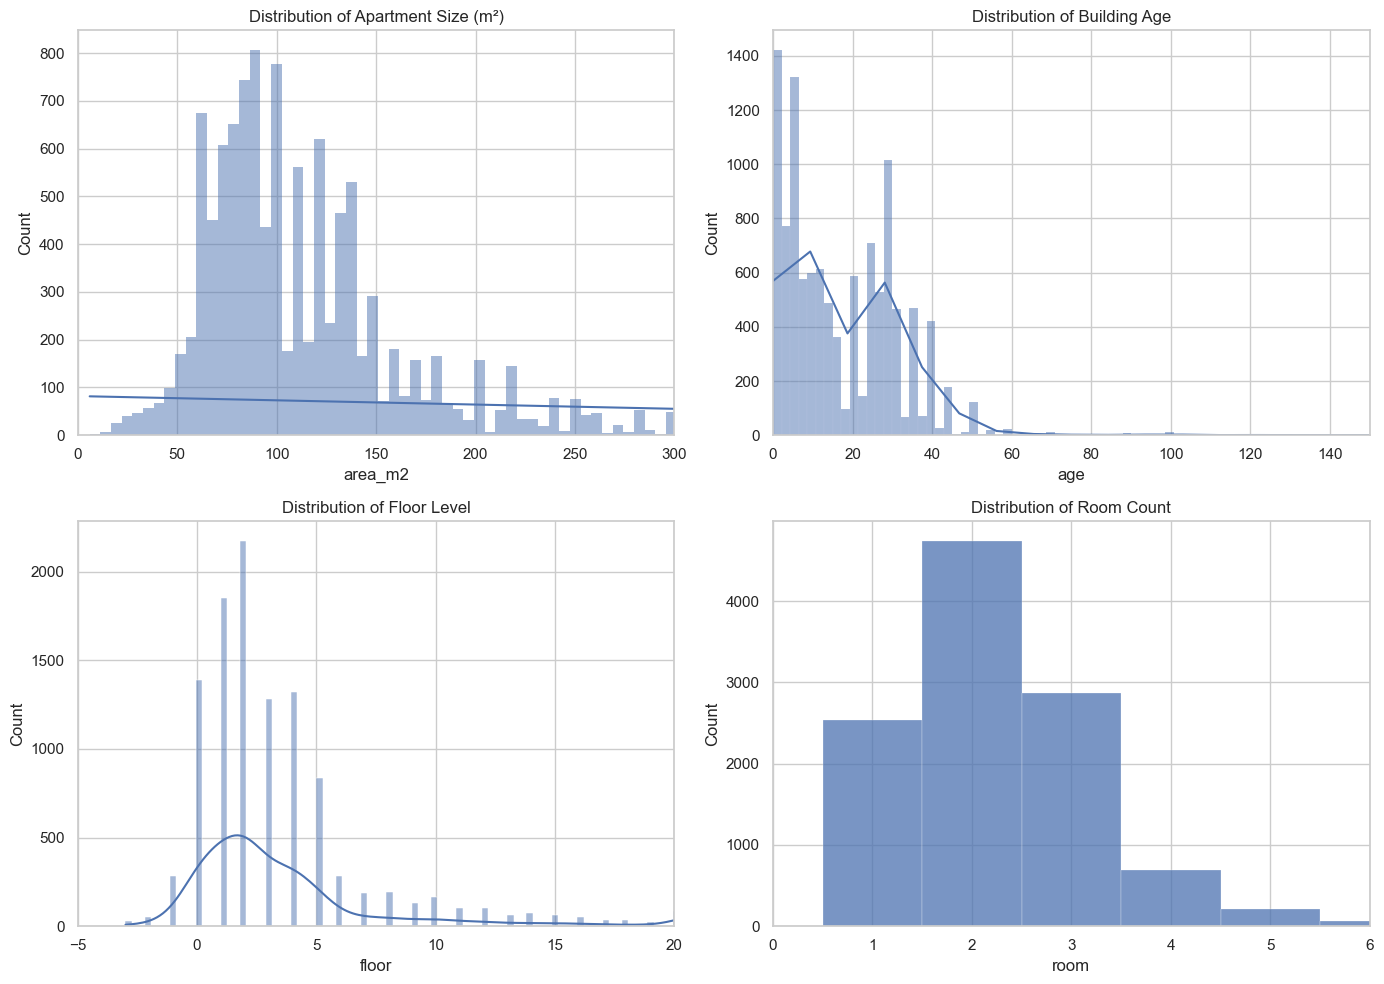

In [313]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# --- Apartment Size ---
sns.histplot(merged_df["area_m2"], kde=True, ax=ax[0,0])
ax[0,0].set_title("Distribution of Apartment Size (m²)")
ax[0,0].set_xlim(0, 300)   

# --- Building Age ---
sns.histplot(merged_df["age"], kde=True, ax=ax[0,1])
ax[0,1].set_title("Distribution of Building Age")
ax[0,1].set_xlim(0, 150)  

# --- Floor Level ---
sns.histplot(merged_df["floor"], kde=True, ax=ax[1,0])
ax[1,0].set_title("Distribution of Floor Level")
ax[1,0].set_xlim(-5, 20)   

# --- Room Count ---
sns.histplot(merged_df["room"], kde=False, discrete=True, ax=ax[1,1])
ax[1,1].set_title("Distribution of Room Count")
ax[1,1].set_xlim(0, merged_df["room"].quantile(0.99)) 

plt.tight_layout()
plt.show()

### Distribution of Earthquake Risk Indicators

Earthquake-related indicators (`damage_ratio`, `casualty_ratio`, `earthquake_risk_index`, `total_buildings`) are examined:

- most neighborhoods appear in the low-risk region,
- a subset shows significantly higher ratios,
- `total_buildings` varies substantially, reflecting neighborhood density differences.

This variation is essential for later risk-price comparisons.


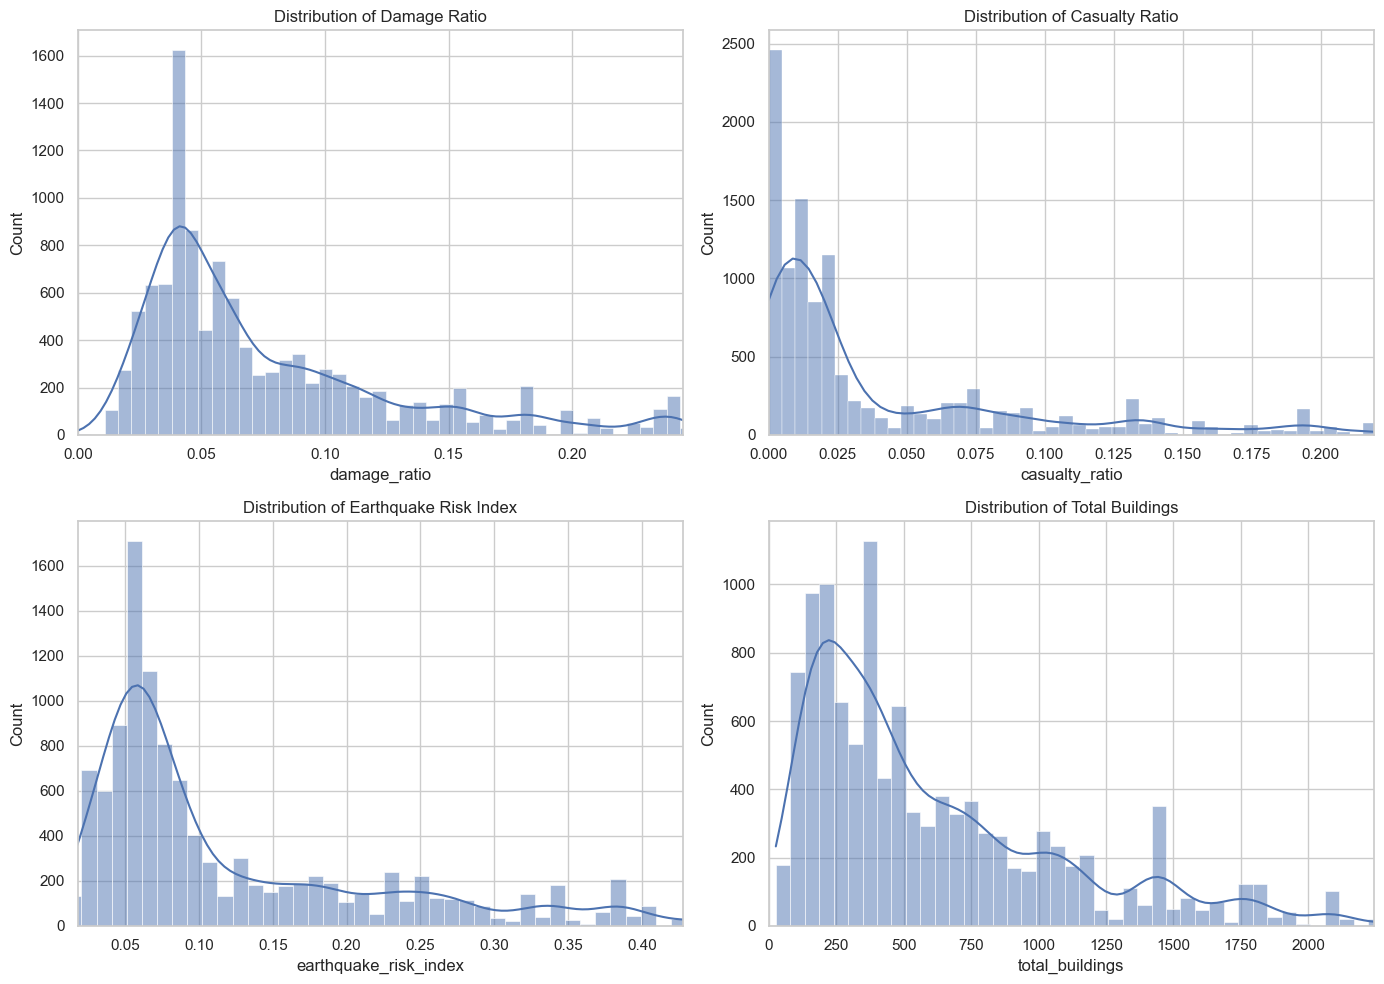

In [315]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(merged_df["damage_ratio"], kde=True, ax=ax[0,0])
ax[0,0].set_title("Distribution of Damage Ratio")
ax[0,0].set_xlim(0, merged_df["damage_ratio"].quantile(0.99))

sns.histplot(merged_df["casualty_ratio"], kde=True, ax=ax[0,1])
ax[0,1].set_title("Distribution of Casualty Ratio")
ax[0,1].set_xlim(0, merged_df["casualty_ratio"].quantile(0.99))

sns.histplot(merged_df["earthquake_risk_index"], kde=True, ax=ax[1,0])
ax[1,0].set_title("Distribution of Earthquake Risk Index")
ax[1,0].set_xlim(
    merged_df["earthquake_risk_index"].quantile(0.01),
    merged_df["earthquake_risk_index"].quantile(0.99)
)

sns.histplot(merged_df["total_buildings"], kde=True, ax=ax[1,1])
ax[1,1].set_title("Distribution of Total Buildings")
ax[1,1].set_xlim(0, merged_df["total_buildings"].quantile(0.99))

plt.tight_layout()
plt.show()

### Distribution of Rental Prices

Histograms and KDE plots for **`price_per_m2`** and **`total_rent`** reveal:

- a long right tail due to luxury listings,
- concentration of most listings in a narrow mid-price range.

Zoomed-in versions (up to the 99th percentile) show the typical market segment more clearly.  
These distributions indicate that transformations (e.g., log) may be useful in later modeling.

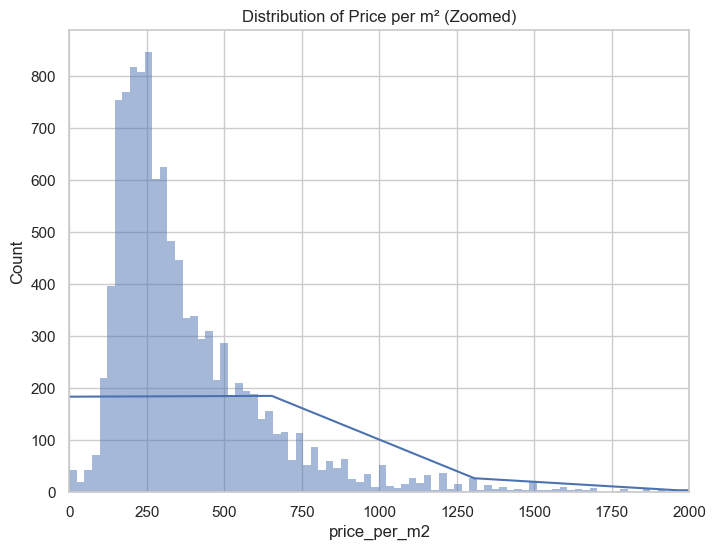

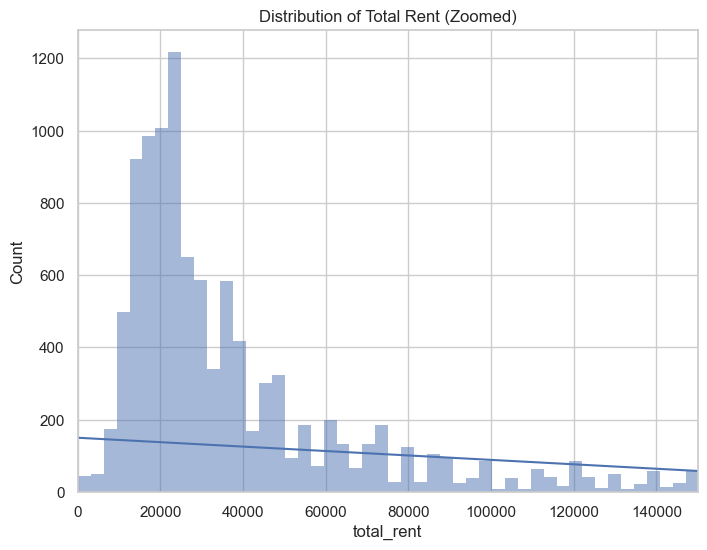

In [296]:
plt.figure(figsize=(8,6))
sns.histplot(merged_df["price_per_m2"], kde=True)
plt.title("Distribution of Price per m² (Zoomed)")
plt.xlabel("price_per_m2")
plt.ylabel("Count")
plt.xlim(0, 2000)
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(merged_df["total_rent"], kde=True)
plt.title("Distribution of Total Rent (Zoomed)")
plt.xlabel("total_rent")
plt.ylabel("Count")
plt.xlim(0, 150000)
plt.show()

## Relationship Between Rent and Property Characteristics

/var/folders/8j/241xzjys27lgf4trblbqkwdc0000gn/T/ipykernel_68080/4199257222.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df.groupby("area_bin")["price_per_m2"]


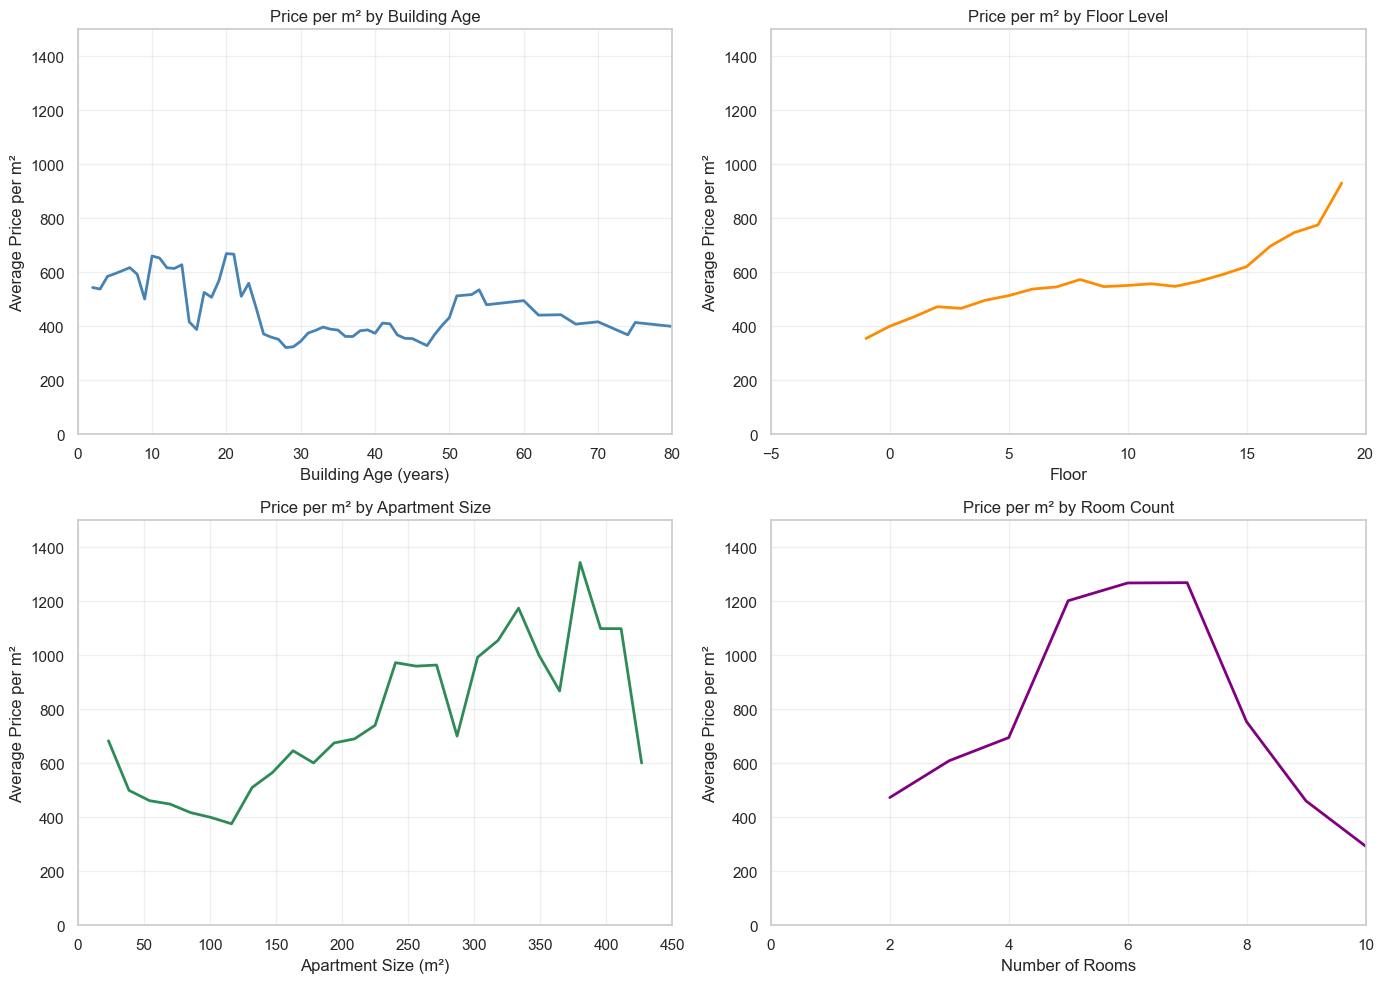

In [297]:

age_group = (
    merged_df.groupby("age")["price_per_m2"]
    .mean()
    .reset_index()
)
age_group["smooth"] = age_group["price_per_m2"].rolling(5, center=True).mean()


floor_group = (
    merged_df.groupby("floor")["price_per_m2"]
    .mean()
    .reset_index()
)
floor_group["smooth"] = floor_group["price_per_m2"].rolling(5, center=True).mean()


area_max = merged_df["area_m2"].quantile(0.99)
area_bins = np.linspace(0, area_max, 30)
merged_df["area_bin"] = pd.cut(merged_df["area_m2"], bins=area_bins)

area_group = (
    merged_df.groupby("area_bin")["price_per_m2"]
    .mean()
    .reset_index()
)
area_group["area_mid"] = area_group["area_bin"].apply(lambda x: x.mid)
area_group["smooth"] = area_group["price_per_m2"].rolling(3, center=True).mean()


room_group = (
    merged_df.groupby("room")["price_per_m2"]
    .mean()
    .reset_index()
)
room_group["smooth"] = room_group["price_per_m2"].rolling(3, center=True).mean()

ymax = merged_df["price_per_m2"].quantile(0.98)

fig, ax = plt.subplots(2, 2, figsize=(14, 10))


ax[0,0].plot(age_group["age"], age_group["smooth"], linewidth=2, color="steelblue")
ax[0,0].set_title("Price per m² by Building Age")
ax[0,0].set_xlabel("Building Age (years)")
ax[0,0].set_ylabel("Average Price per m²")
ax[0,0].set_xlim(0, 80)
ax[0,0].set_ylim(0, ymax)
ax[0,0].grid(True, alpha=0.3)


ax[0,1].plot(floor_group["floor"], floor_group["smooth"], linewidth=2, color="darkorange")
ax[0,1].set_title("Price per m² by Floor Level")
ax[0,1].set_xlabel("Floor")
ax[0,1].set_ylabel("Average Price per m²")
ax[0,1].set_xlim(-5, 20)
ax[0,1].set_ylim(0, ymax)
ax[0,1].grid(True, alpha=0.3)


ax[1,0].plot(area_group["area_mid"], area_group["smooth"], linewidth=2, color="seagreen")
ax[1,0].set_title("Price per m² by Apartment Size")
ax[1,0].set_xlabel("Apartment Size (m²)")
ax[1,0].set_ylabel("Average Price per m²")
ax[1,0].set_xlim(0, area_max)
ax[1,0].set_ylim(0, ymax)
ax[1,0].grid(True, alpha=0.3)


ax[1,1].plot(room_group["room"], room_group["smooth"], linewidth=2, color="purple")
ax[1,1].set_title("Price per m² by Room Count")
ax[1,1].set_xlabel("Number of Rooms")
ax[1,1].set_ylabel("Average Price per m²")
ax[1,1].set_xlim(0, 10)
ax[1,1].set_ylim(0, ymax)
ax[1,1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

General patterns:

- Newer buildings show slightly higher prices per m²; price gradually declines with age.
- Price increases with floor level up to mid-high floors.
- Very small units have higher m² prices; mid-sized units have lower m² prices; very large units rise again.
- Room count exhibits an inverted-U pattern: 3–6 rooms peak in price per m² before flattening.

These systematic patterns show that property characteristics strongly explain rental price variation.

###  Relationship Between Rent and Earthquake Risk

/var/folders/8j/241xzjys27lgf4trblbqkwdc0000gn/T/ipykernel_68080/1604392745.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pd.DataFrame({"x_bin": binned, "y": series_y})
/var/folders/8j/241xzjys27lgf4trblbqkwdc0000gn/T/ipykernel_68080/1604392745.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pd.DataFrame({"x_bin": binned, "y": series_y})
/var/folders/8j/241xzjys27lgf4trblbqkwdc0000gn/T/ipykernel_68080/1604392745.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True

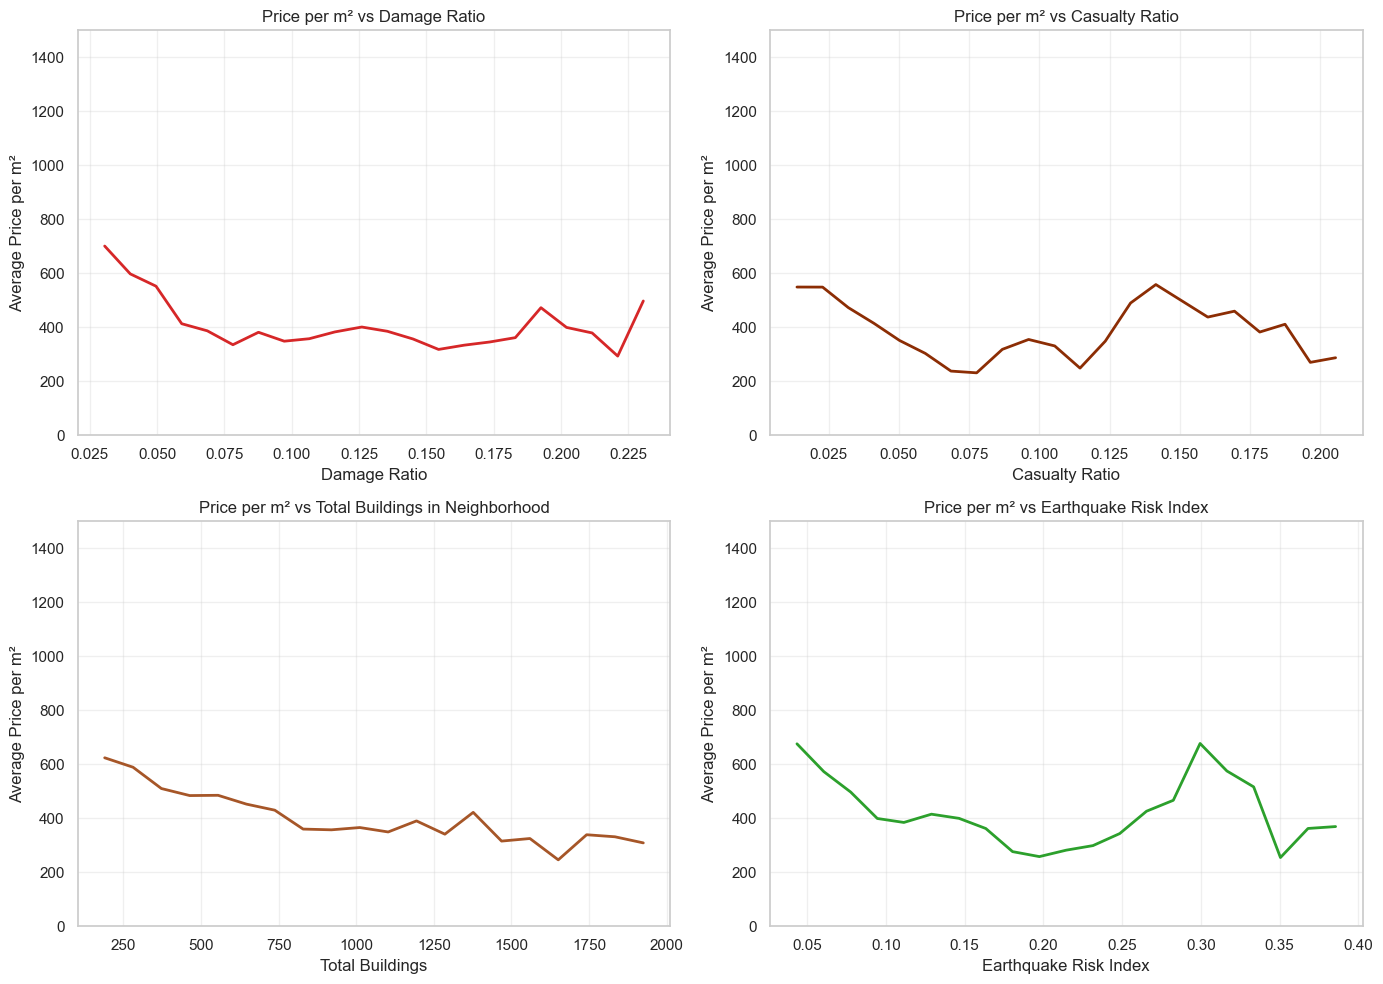

In [298]:

ymax = merged_df["price_per_m2"].quantile(0.98)

def make_binned_curve(series_x, series_y, n_bins=25, min_count=40, smooth_window=3):
    """
    x'i binleyip her bin için ortalama y hesaplar,
    az gözlemli binleri atar ve rolling smoothing uygular.
    """

    x_min = series_x.quantile(0.01)
    x_max = series_x.quantile(0.99)
    bins = np.linspace(x_min, x_max, n_bins)

    binned = pd.cut(series_x, bins=bins)
    grouped = (
        pd.DataFrame({"x_bin": binned, "y": series_y})
        .groupby("x_bin")["y"]
        .agg(["mean", "count"])
        .reset_index()
    )

 
    grouped["x_mid"] = grouped["x_bin"].apply(lambda b: b.mid)


    grouped = grouped[grouped["count"] >= min_count]

    grouped["smooth"] = grouped["mean"].rolling(smooth_window, center=True).mean()

    return grouped

damage_curve   = make_binned_curve(merged_df["damage_ratio"],          merged_df["price_per_m2"])
casualty_curve = make_binned_curve(merged_df["casualty_ratio"],        merged_df["price_per_m2"])
build_curve    = make_binned_curve(merged_df["total_buildings"],       merged_df["price_per_m2"])
risk_curve     = make_binned_curve(merged_df["earthquake_risk_index"], merged_df["price_per_m2"])

fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# 1) Damage ratio
ax[0,0].plot(damage_curve["x_mid"], damage_curve["smooth"],
             linewidth=2, color="#d62728")
ax[0,0].set_title("Price per m² vs Damage Ratio")
ax[0,0].set_xlabel("Damage Ratio")
ax[0,0].set_ylabel("Average Price per m²")
ax[0,0].set_ylim(0, ymax)
ax[0,0].grid(True, alpha=0.3)

# 2) Casualty ratio
ax[0,1].plot(casualty_curve["x_mid"], casualty_curve["smooth"],
             linewidth=2, color="#8c2d04")
ax[0,1].set_title("Price per m² vs Casualty Ratio")
ax[0,1].set_xlabel("Casualty Ratio")
ax[0,1].set_ylabel("Average Price per m²")
ax[0,1].set_ylim(0, ymax)
ax[0,1].grid(True, alpha=0.3)

# 3) Total buildings
ax[1,0].plot(build_curve["x_mid"], build_curve["smooth"],
             linewidth=2, color="#a65628")
ax[1,0].set_title("Price per m² vs Total Buildings in Neighborhood")
ax[1,0].set_xlabel("Total Buildings")
ax[1,0].set_ylabel("Average Price per m²")
ax[1,0].set_ylim(0, ymax)
ax[1,0].grid(True, alpha=0.3)

# 4) Earthquake risk index
ax[1,1].plot(risk_curve["x_mid"], risk_curve["smooth"],
             linewidth=2, color="#2ca02c")
ax[1,1].set_title("Price per m² vs Earthquake Risk Index")
ax[1,1].set_xlabel("Earthquake Risk Index")
ax[1,1].set_ylabel("Average Price per m²")
ax[1,1].set_ylim(0, ymax)
ax[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Key observations:

- Higher damage and casualty ratios correspond to a gradual decline in average m² price.
- Neighborhoods with more buildings tend to have lower m² prices—possibly reflecting higher-density, lower-income districts.
- As the earthquake risk index increases, upper-range m² prices diminish and variability shrinks.

Overall, earthquake risk appears to have a **negative but weaker** effect compared to structural apartment features.

In [299]:
# Create risk_level categories based on earthquake_risk_index
merged_df["risk_level"] = pd.qcut(
    merged_df["earthquake_risk_index"],
    3,
    labels=["low", "medium", "high"]
)

merged_df["risk_level"].value_counts()

risk_level
low       3750
high      3717
medium    3710
Name: count, dtype: int64

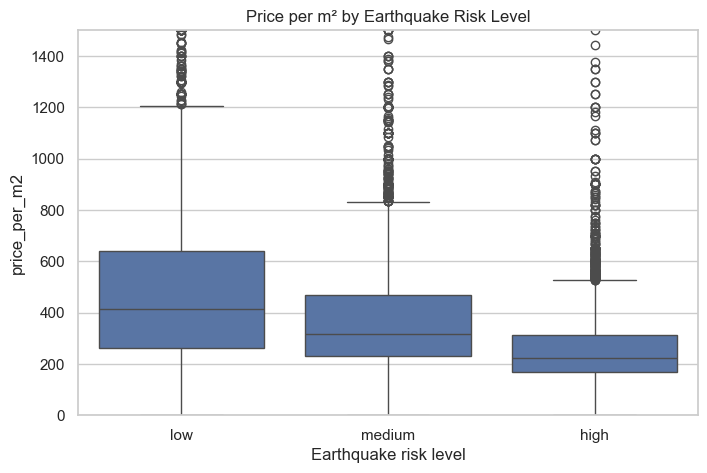

In [300]:
# Boxplots of price_per_m2 across risk levels
plt.figure(figsize=(8,5))
sns.boxplot(
    data=merged_df,
    x="risk_level",
    y="price_per_m2",
    order=["low", "medium", "high"]
)
plt.title("Price per m² by Earthquake Risk Level")
plt.xlabel("Earthquake risk level")
plt.ylabel("price_per_m2")
plt.ylim(0, merged_df["price_per_m2"].quantile(0.98))
plt.show()

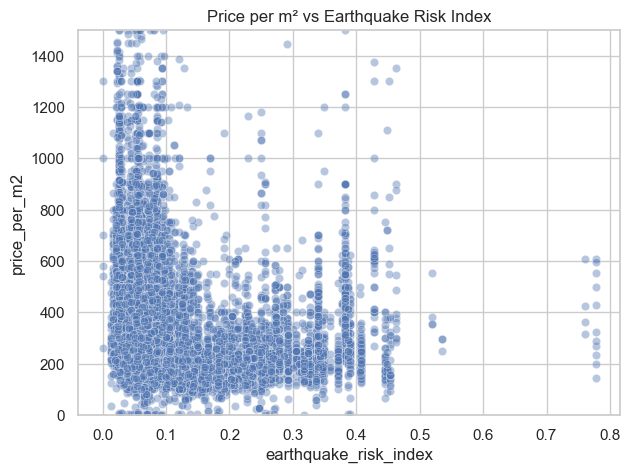

In [301]:
# Scatter: price_per_m2 vs earthquake_risk_index
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=merged_df,
    x="earthquake_risk_index",
    y="price_per_m2",
    alpha=0.4
)
plt.title("Price per m² vs Earthquake Risk Index")
plt.xlabel("earthquake_risk_index")
plt.ylabel("price_per_m2")
plt.ylim(0, merged_df["price_per_m2"].quantile(0.98))
plt.show()

Visual observations:

Neighborhoods are categorized into **low**, **medium**, and **high** risk using the earthquake risk index.  
Boxplots and scatterplots show:

- Higher-risk neighborhoods have lower median price per m².
- Low-risk neighborhoods show higher medians and a wider upper tail.

This suggests that perceived seismic safety carries a measurable, though not dominant, premium.

## 9. Summary of Exploratory Data Analysis (EDA)

The main insights from the EDA phase are:

- The merged dataset successfully integrates rental listings with detailed neighborhood-level earthquake indicators.
- Earthquake variables were transformed into ratios and a unified **earthquake risk index**, enabling consistent comparisons.
- Rental prices are heavily right-skewed and vary substantially across the city.
- **Property features** (age, floor, size, room count) show clear, strong, and interpretable relationships with price per m².
- **Earthquake risk** shows a **negative but moderate** influence on m² prices: higher-risk areas tend to be cheaper, but the effect is smaller than the influence of property characteristics.
- These results point toward the next step: formally testing hypotheses H1–H4 to quantify the magnitude and significance of these relationships.